## Generating Benchmark Data for M5

The data is taken from the [M5 Forecasting - Accuracy](https://www.kaggle.com/c/m5-forecasting-accuracy) challenge on Kaggle, a competiton organized by The Makridakis Open Forecasting Center (MOFC) at the University of Nicosia ($50,000).

In [2]:
ROOT = "/data/cmu/large-scale-hts-reconciliation/"
data_dir = ROOT + "notebooks/"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tqdm import tqdm

Importing plotly failed. Interactive plots will not work.


In [4]:
df = pd.read_csv(data_dir + 'sales_train_evaluation.csv').fillna(0)
df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [5]:
import collections
collections.Counter(df['dept_id'].values), \
collections.Counter(df['cat_id'].values), \
collections.Counter(df['store_id'].values), \
collections.Counter(df['state_id'].values)

(Counter({'HOBBIES_1': 4160,
          'HOBBIES_2': 1490,
          'HOUSEHOLD_1': 5320,
          'HOUSEHOLD_2': 5150,
          'FOODS_1': 2160,
          'FOODS_2': 3980,
          'FOODS_3': 8230}),
 Counter({'HOBBIES': 5650, 'HOUSEHOLD': 10470, 'FOODS': 14370}),
 Counter({'CA_1': 3049,
          'CA_2': 3049,
          'CA_3': 3049,
          'CA_4': 3049,
          'TX_1': 3049,
          'TX_2': 3049,
          'TX_3': 3049,
          'WI_1': 3049,
          'WI_2': 3049,
          'WI_3': 3049}),
 Counter({'CA': 12196, 'TX': 9147, 'WI': 9147}))

Forecasting is done on a separate file. Here's what it roughly looks like.

```python
import dask.dataframe as dd

ddf = dd.from_pandas(df, npartitions=120) # over-subscribing

forecast_horizon = 100

def predict(row):
    data = pd.DataFrame({'ds': (row.index)[1:][-forecast_horizon:], 'y':(row.values)[1:][-forecast_horizon:]})
    m = Prophet()
    m.fit(data)
    
    future = m.make_future_dataframe(periods=forecast_horizon)
    future.tail()
    forecast = m.predict(future)

    return row.Page, forecast[['yhat']][-forecast_horizon:].values.reshape(-1)
```

### Sanity check by plotting

In [8]:
import pickle
predictions = pickle.load(open(data_dir + 'm5_prediction_raw/result_m5.pkl', 'rb'))

SMAPE:  115.003


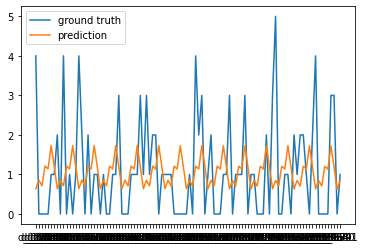

In [9]:
import seaborn as sns

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

pred = predictions[0][1]
index = list(df.columns)[1:][-100:]
gt = df.iloc[0,:].values[-100:]

sns.lineplot(x=index, y=gt, label='ground truth')
sns.lineplot(x=index, y=pred, label='prediction')

print("SMAPE: ", smape(gt, pred).round(3))

In [10]:
predictions[1]

('HOBBIES_1_002_CA_1_evaluation',
 array([0.22624099, 0.22582096, 0.16103746, 0.28918591, 0.09575668,
        0.27366628, 0.27320232, 0.22887389, 0.22845386, 0.16367036,
        0.29181882, 0.09838958, 0.27629918, 0.27583522, 0.23150679,
        0.23108677, 0.16630326, 0.29445172, 0.10102248, 0.27893208,
        0.27846812, 0.2341397 , 0.23371967, 0.16893616, 0.29708462,
        0.10365538, 0.28156498, 0.28110102, 0.2367726 , 0.23635257,
        0.17156907, 0.29971752, 0.10628828, 0.28419788, 0.28373392,
        0.2394055 , 0.23898547, 0.17420197, 0.30235042, 0.10892119,
        0.28683079, 0.28636683, 0.2420384 , 0.24161837, 0.17683487,
        0.30498332, 0.11155409, 0.28946369, 0.28899973, 0.2446713 ,
        0.24425127, 0.17946777, 0.30761623, 0.11418699, 0.29209659,
        0.29163263, 0.2473042 , 0.24688418, 0.18210067, 0.31024913,
        0.11681989, 0.29472949, 0.29426553, 0.24993711, 0.24951708,
        0.18473357, 0.31288203, 0.11945279, 0.29736239, 0.29689843,
        0.2525

### Export trace for benchmarking 

In [12]:
time_index = index
disagg = []

for p, (i, g) in tqdm(zip(predictions, df.iterrows()), total = len(df)):
    assert(p[0] == g.id)
    disagg.append((g.id, p[1], g.values[-100:]))

100%|███████████████████████████████████████████| 30490/30490 [00:02<00:00, 11640.86it/s]


In [13]:
node_id_mapping = {'node_id': [], 'name': []}

pred_tensor = np.zeros((len(disagg), 100))
gt_tensor = np.zeros((len(disagg), 100))

for i, (name, prediction, gt) in tqdm(enumerate(disagg)):
    pred_tensor[i, :] = prediction
    gt_tensor[i, :] = gt
    node_id_mapping['node_id'].append(i)
    node_id_mapping['name'].append(name)

30490it [00:00, 136889.17it/s]


### Compiling the hierarchies

In [17]:
node_id_map_df = pd.DataFrame(node_id_mapping)

In [18]:
node_id_map_df

,node_id,name
0,0,HOBBIES_1_001_CA_1_evaluation
1,1,HOBBIES_1_002_CA_1_evaluation
2,2,HOBBIES_1_003_CA_1_evaluation
3,3,HOBBIES_1_004_CA_1_evaluation
4,4,HOBBIES_1_005_CA_1_evaluation
...,...,...
30485,30485,FOODS_3_823_WI_3_evaluation
30486,30486,FOODS_3_824_WI_3_evaluation
30487,30487,FOODS_3_825_WI_3_evaluation
30488,30488,FOODS_3_826_WI_3_evaluation


In [19]:
node_id_map_df['level_4'] = node_id_map_df['name'].apply(lambda x: '_'.join(x.split('_')[:-1]))
node_id_map_df['level_3'] = node_id_map_df['name'].apply(lambda x: '_'.join(x.split('_')[:-3]))
node_id_map_df['level_2'] = node_id_map_df['name'].apply(lambda x: '_'.join(x.split('_')[:-4]))
node_id_map_df['level_1'] = node_id_map_df['name'].apply(lambda x: x.split('_')[-6])

In [20]:
node_id_map_df

,node_id,name,level_4,level_3,level_2,level_1
0,0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES
1,1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES
2,2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES
3,3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES
4,4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES
...,...,...,...,...,...,...
30485,30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS
30486,30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS
30487,30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS
30488,30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS


In [59]:
node_id_map = dict(zip(node_id_map_df['node_id'].values, node_id_map_df['level_4'].values))

In [21]:
parent_node_mapping = {'node_id': [], 'name': []}

level3 = list(set(node_id_map_df['level_3'].values))
level2 = list(set(node_id_map_df['level_2'].values))
level1 = list(set(node_id_map_df['level_1'].values))

curr_sum = len(node_id_map_df)

for s in [level3, level2, level1]:
    for i, v in enumerate(s):
        parent_node_mapping['node_id'].append(i + curr_sum)
        parent_node_mapping['name'].append(v)
    curr_sum += len(s)

In [67]:
node_id_map_df

,node_id,name,level_4,level_3,level_2,level_1
0,0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES
1,1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES
2,2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES
3,3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES
4,4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES
...,...,...,...,...,...,...
30485,30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS
30486,30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS
30487,30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS
30488,30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS


In [87]:
parent_node_mapping_df = pd.DataFrame(parent_node_mapping)
parent_map = dict(zip(parent_node_mapping_df.name.values, parent_node_mapping_df.node_id.values))
parent_map_inv = {v:k for k,v in parent_map.items()}

In [81]:
parent_node_mapping_df

,node_id,name
0,30490,HOUSEHOLD_1_518
1,30491,FOODS_3_700
2,30492,HOBBIES_2_032
3,30493,HOUSEHOLD_1_536
4,30494,HOBBIES_1_062
...,...,...
3054,33544,FOODS_2
3055,33545,FOODS_1
3056,33546,HOBBIES
3057,33547,HOUSEHOLD


In [78]:
gt_parent_tensor = np.zeros((curr_sum - len(node_id_map_df), 100)).astype(np.int64)

for (name, prediction, gt), (i, ro) in tqdm(zip(disagg, node_id_map_df.iterrows())):
    gt_parent_tensor[int(parent_map[ro.level_3] - len(node_id_map_df)), :] += gt.astype(np.int64)
    gt_parent_tensor[int(parent_map[ro.level_2] - len(node_id_map_df)), :] += gt.astype(np.int64)
    gt_parent_tensor[int(parent_map[ro.level_1] - len(node_id_map_df)), :] += gt.astype(np.int64)

30490it [00:03, 10038.42it/s]


In [25]:
node_id_map_df.to_csv(data_dir + 'm5_prediction_raw/node_id_map.csv', index=False)
parent_node_mapping_df.to_csv(data_dir + 'm5_prediction_raw/parent_node_id_map.csv', index=False)

In [80]:
np.save(open(data_dir + 'm5_prediction_raw/pred_tensor.npy', 'wb'), pred_tensor)
np.save(open(data_dir + 'm5_prediction_raw/gt_tensor.npy', 'wb'), gt_tensor)
np.save(open(data_dir + 'm5_prediction_raw/gt_tensor_parent.npy', 'wb'), gt_parent_tensor)

In [27]:
from collections import Counter
Counter(node_id_map_df.level_1.values)

Counter({'HOBBIES': 5650, 'HOUSEHOLD': 10470, 'FOODS': 14370})

In [28]:
Counter(node_id_map_df.level_2.values)

Counter({'HOBBIES_1': 4160,
         'HOBBIES_2': 1490,
         'HOUSEHOLD_1': 5320,
         'HOUSEHOLD_2': 5150,
         'FOODS_1': 2160,
         'FOODS_2': 3980,
         'FOODS_3': 8230})

### Format to Nixtla standard

In [94]:
tags = {}
tags['Cat'] = node_id_map_df.level_1.unique()
tags['Cat/Dept'] = node_id_map_df.level_2.unique()
tags['Cat/Dept/Item'] = node_id_map_df.level_3.unique()
tags['Cat/Dept/Item/State'] = node_id_map_df.level_4.unique()

In [95]:
tags

{'Cat': array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object),
 'Cat/Dept': array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
        'FOODS_2', 'FOODS_3'], dtype=object),
 'Cat/Dept/Item': array(['HOBBIES_1_001', 'HOBBIES_1_002', 'HOBBIES_1_003', ...,
        'FOODS_3_825', 'FOODS_3_826', 'FOODS_3_827'], dtype=object),
 'Cat/Dept/Item/State': array(['HOBBIES_1_001_CA_1', 'HOBBIES_1_002_CA_1', 'HOBBIES_1_003_CA_1',
        ..., 'FOODS_3_825_WI_3', 'FOODS_3_826_WI_3', 'FOODS_3_827_WI_3'],
       dtype=object)}

In [99]:
y_gt = {'unique_id': [], 'ds': [], 'y': []}
y_hat = {'unique_id': [], 'ds': [], 'y': []}

for _, ro in tqdm(node_id_map_df.iterrows()):
    for i in range(100):
        y_gt['unique_id'].append(node_id_map[ro.name])
        y_gt['ds'].append(time_index[i])
        y_gt['y'].append(gt_tensor[ro.node_id, i])
        
        y_hat['unique_id'].append(node_id_map[ro.name])
        y_hat['ds'].append(time_index[i])
        y_hat['y'].append(pred_tensor[ro.node_id, i])
        
for _, ro in tqdm(parent_node_mapping_df.iterrows()):
    for i in range(100):
        y_gt['unique_id'].append(parent_map_inv[ro.node_id])
        y_gt['ds'].append(time_index[i])
        y_gt['y'].append(gt_parent_tensor[ro.node_id - len(node_id_map_df), i])
        
        # Nixtla has to accept all inputs
        y_hat['unique_id'].append(parent_map_inv[ro.node_id])
        y_hat['ds'].append(time_index[i])
        y_hat['y'].append(0)

30490it [00:51, 592.24it/s]
3059it [00:07, 425.63it/s]


In [100]:
Y_gt = pd.DataFrame(y_gt)
Y_hat = pd.DataFrame(y_hat)
Y_hat.rename(columns = {'y': 'prophet'}, inplace=True)

Y_gt.to_csv(data_dir + 'm5_prediction_raw/nixtla_y_gt.csv', index=False)
Y_hat.to_csv(data_dir + 'm5_prediction_raw/nixtla_y_hat.csv', index=False)

In [93]:
import gc
nrow = len(tags['Cat']) + len(tags['Cat/Dept']) + len(tags['Cat/Dept/Item']) + len(tags['Cat/Dept/Item/State'])
ncol = len(tags['Cat/Dept/Item/State'])

columns = list(tags['Cat/Dept/Item/State'])
rows = list(tags['Cat']) + list(tags['Cat/Dept']) + list(tags['Cat/Dept/Item']) + list(tags['Cat/Dept/Item/State'])

In [45]:
raw_S = np.zeros((nrow, ncol))

In [47]:
rows_map = {v:k for k,v in dict(enumerate(rows)).items()}
columns_map = {v:k for k,v in dict(enumerate(columns)).items()}

In [48]:
for i, ro in tqdm(node_id_map_df.iterrows(), total=len(node_id_map_df)):
    co = columns_map[ro.level_4]
    ro4 = rows_map[ro.level_4]
    ro3 = rows_map[ro.level_3]
    ro2 = rows_map[ro.level_2]
    ro1 = rows_map[ro.level_1]
    raw_S[ro1, co] = 1
    raw_S[ro2, co] = 1
    raw_S[ro3, co] = 1
    raw_S[ro4, co] = 1

100%|███████████████████████████████████████████| 30490/30490 [00:02<00:00, 11188.33it/s]


In [53]:
S_df = pd.DataFrame(data=raw_S, dtype=int)
S_df.columns = columns
S_df.index = rows

In [96]:
pickle.dump(S_df, open('m5_prediction_raw/nixtla_s.pkl', 'wb'))

In [97]:
pickle.dump(tags, open('m5_prediction_raw/tags.pkl', 'wb'))

In [98]:
S_df

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
HOBBIES,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
HOUSEHOLD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
HOBBIES_1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
HOBBIES_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
FOODS_3_824_WI_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
FOODS_3_825_WI_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
FOODS_3_826_WI_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
